In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/radioml2018/datasets.desktop
/kaggle/input/radioml2018/classes-fixed.json
/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5
/kaggle/input/radioml2018/classes-fixed.txt
/kaggle/input/radioml2018/LICENSE.TXT
/kaggle/input/radioml2018/classes.txt


In [2]:
import numpy as np
import pandas as pd
import h5py
import json
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
import tensorflow.keras as tk
from keras.layers import LeakyReLU
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-11-13 06:41:02.777080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763016062.987757      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763016063.040081      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
dataset_file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5","r")

# Read the HDF5 groups
X = dataset_file['X'] # I_phase and Q_phase
Y = dataset_file['Y'] # Modulation onehot
Z = dataset_file['Z'] # SNR

In [4]:
# Print the contents of the classes-fixed.txt file
with open('/kaggle/input/radioml2018/classes-fixed.txt') as f:
    content = f.read()
    print(content)

"""
 ____________________________________
|             Classes.txt            |
|____________________________________|
|idx |    Original   |     Fixed     |
|  0 |  '32PSK'      |  'OOK'        |
|  1 |  '16APSK'     |  '4ASK'       |
|  2 |  '32QAM'      |  '8ASK'       |
|  3 |  'FM'         |  'BPSK'       |
|  4 |  'GMSK'       |  'QPSK'       |
|  5 |  '32APSK'     |  '8PSK'       |
|  6 |  'OQPSK'      |  '16PSK'      |
|  7 |  '8ASK'       |  '32PSK'      |
|  8 |  'BPSK'       |  '16APSK'     |
|  9 |  '8PSK'       |  '32APSK'     |
| 10 |  'AM-SSB-SC'  |  '64APSK'     |
| 11 |  '4ASK'       |  '128APSK'    |
| 12 |  '16PSK'      |  '16QAM'      |
| 13 |  '64APSK'     |  '32QAM'      |
| 14 |  '128QAM'     |  '64QAM'      |
| 15 |  '128APSK'    |  '128QAM'     |
| 16 |  'AM-DSB-SC'  |  '256QAM'     |
| 17 |  'AM-SSB-WC'  |  'AM-SSB-WC'  |
| 18 |  '64QAM'      |  'AM-SSB-SC'  |
| 19 |  'QPSK'       |  'AM-DSB-WC'  |
| 20 |  '256QAM'     |  'AM-DSB-SC'  |
| 21 |  'AM-DSB-WC'  |

In [5]:
# Function to load and parse the classes-fixed.json file
def load_fixed_classes(json_file_path):
    with open(json_file_path) as f:
        data = json.load(f)
    return data

# Load the class names from the JSON file
fixed_classes = load_fixed_classes('/kaggle/input/radioml2018/classes-fixed.json')

# Print the fixed class names
print(fixed_classes)

['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [6]:
def find_modulation_snr_indices(modulation_name, snr_level, classes_fixed, Y, Z):
    modulation_index = classes_fixed.index(modulation_name)
    indices = [i for i, (label, snr) in enumerate(zip(Y, Z)) if np.argmax(label) == modulation_index and snr == snr_level]
    return indices

In [30]:
def plot_signals_by_modulation_snr(modulation_name, snr_level, num_samples):
    indices = find_modulation_snr_indices(modulation_name, snr_level, fixed_classes, Y, Z)
    if len(indices) < num_samples:
        print(f"Not enough samples for {modulation_name} with SNR {snr_level} dB. Found only {len(indices)} samples.")
        return
    print(f"{modulation_name} Plots")
    samples = np.random.choice(indices, num_samples, replace=False)

    for sample in samples:
        plt.figure(figsize=(30, 6))

        I_phase = X[sample, :, 0]
        Q_phase = X[sample, :, 1]
        magnitude = np.sqrt((I_phase**2) + (Q_phase**2))

        plt.subplot(1, 3, 1)
        plt.plot(I_phase)
        plt.title(f'{modulation_name} - In-phase (I) (SNR: {snr_level} dB)')

        plt.subplot(1, 3, 2)
        plt.plot(Q_phase)
        plt.title(f'{modulation_name} - Quadrature-phase (Q) (SNR: {snr_level} dB)')

        plt.subplot(1, 3, 3)
        plt.plot(magnitude)
        plt.title(f'{modulation_name} - Magnitude (SNR: {snr_level} dB)')

        plt.tight_layout()
        plt.show()

OOK Plots


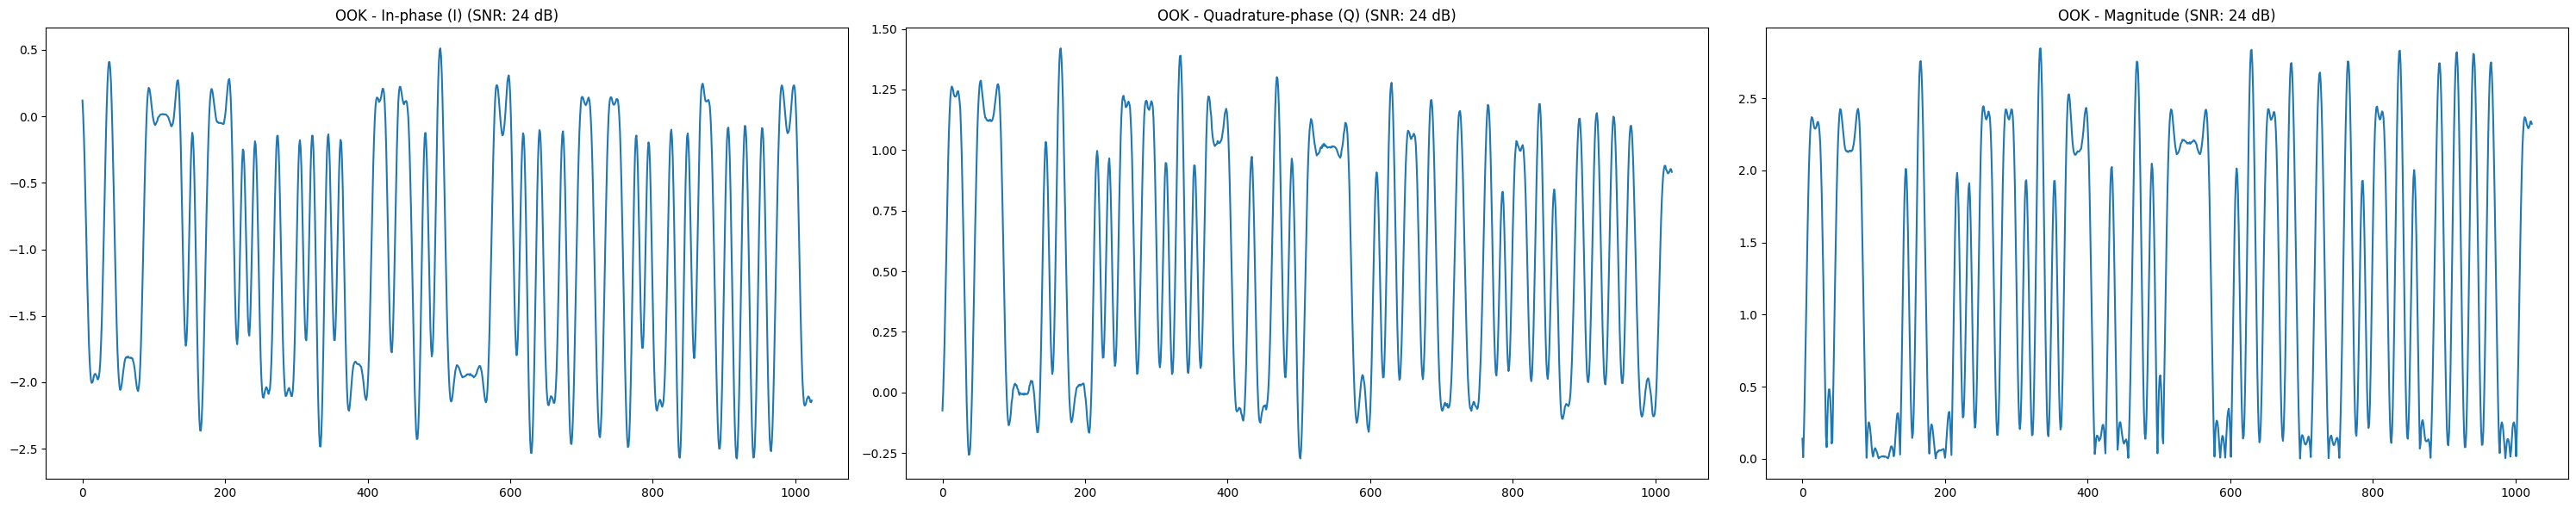

In [31]:
plot_signals_by_modulation_snr('OOK', 24, 1)

In [9]:
print(fixed_classes)

['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [10]:
selected_modulation_classes = ['OOK', 'BPSK', 'AM-SSB-SC', 'AM-SSB-WC', 'AM-DSB-SC', 'FM']

selected_classes_id = [fixed_classes.index(cls) for cls in selected_modulation_classes]

N_SNR = 4 # from 30 SNR to 22 SNR

# Building dataset as per our need, using only the clean data i.e high SNR
X_data = None
y_data = None

for id in selected_classes_id:
    X_slice = dataset_file['X'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]
    y_slice = dataset_file['Y'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]
    
    if X_data is not None:
        X_data = np.concatenate([X_data, X_slice], axis=0)
        y_data = np.concatenate([y_data, y_slice], axis=0)
    else:
        X_data = X_slice
        y_data = y_slice

X_data = X_data.reshape(len(X_data), 32, 32, 2)

y_data_df = pd.DataFrame(y_data)
y_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
for column in y_data_df.columns:
    if sum(y_data_df[column]) == 0:
        y_data_df = y_data_df.drop(columns=[column])

y_data_df.columns = selected_modulation_classes
y_data_df.head()

,OOK,BPSK,AM-SSB-SC,AM-SSB-WC,AM-DSB-SC,FM
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [12]:

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_df, test_size=0.2)

In [13]:
def create_model():
    learning_rate = 0.0001
    i_input = keras.layers.Input(shape=(32,32,1))
    q_input = keras.layers.Input(shape=(32,32,1))

    cnn_q_1 = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(q_input)
    cnn_q_1_2 = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(cnn_q_1)
    pool_q_1 = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_q_1_2)
    cnn_q_2 = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(pool_q_1)
    cnn_q_2_2 = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(cnn_q_2)
    pool_q_2 = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_q_2_2)
    flatten_q = tk.layers.Flatten()(pool_q_2)
    
    cnn_i_1 = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(i_input)
    cnn_i_1_2 = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(cnn_i_1)
    pool_i_1 = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_i_1_2)
    cnn_i_2 = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(pool_i_1)
    cnn_i_2_2 = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(cnn_i_2)
    pool_i_2 = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_i_2_2)
    flatten_i = tk.layers.Flatten()(pool_i_2)
    
    concat = keras.layers.concatenate([flatten_q, flatten_i])
    
    reshape = keras.layers.Reshape((1, -1))(concat)
    lstm = tk.layers.LSTM(256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(reshape)
    
    dense1 = keras.layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(lstm)
    dropout1 = tk.layers.Dropout(0.5)(dense1)
    
    dense2 = keras.layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(dropout1)
    dropout2 = tk.layers.Dropout(0.5)(dense2)
    
    dense3 = keras.layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(dropout2)
    dropout3 = tk.layers.Dropout(0.5)(dense3)
    
    dense4 = keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(dropout3)
    dropout4 = tk.layers.Dropout(0.5)(dense4)
    
    dense5 = keras.layers.Dense(32, activation=LeakyReLU(alpha=0.1))(dropout4)
    outputs = keras.layers.Dense(len(selected_classes_id), activation='softmax')(dense5)
    
    model = keras.Model(inputs=[i_input, q_input], outputs=outputs)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=tk.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [14]:
model = create_model()
batch_size = 64
epochs = 25

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = tk.callbacks.EarlyStopping(monitor="accuracy", min_delta=0, patience=10)

modelckpt_callback = tk.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1763016113.626372      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 30, 30,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 13, 13,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 11, 11,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 11, 11,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 128) │    147,584 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 9, 9, 128) │    147,584 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 4096)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 22,826,036 (87.07 MB)

 Trainable params: 7,608,678 (29.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,217,358 (58.05 MB)

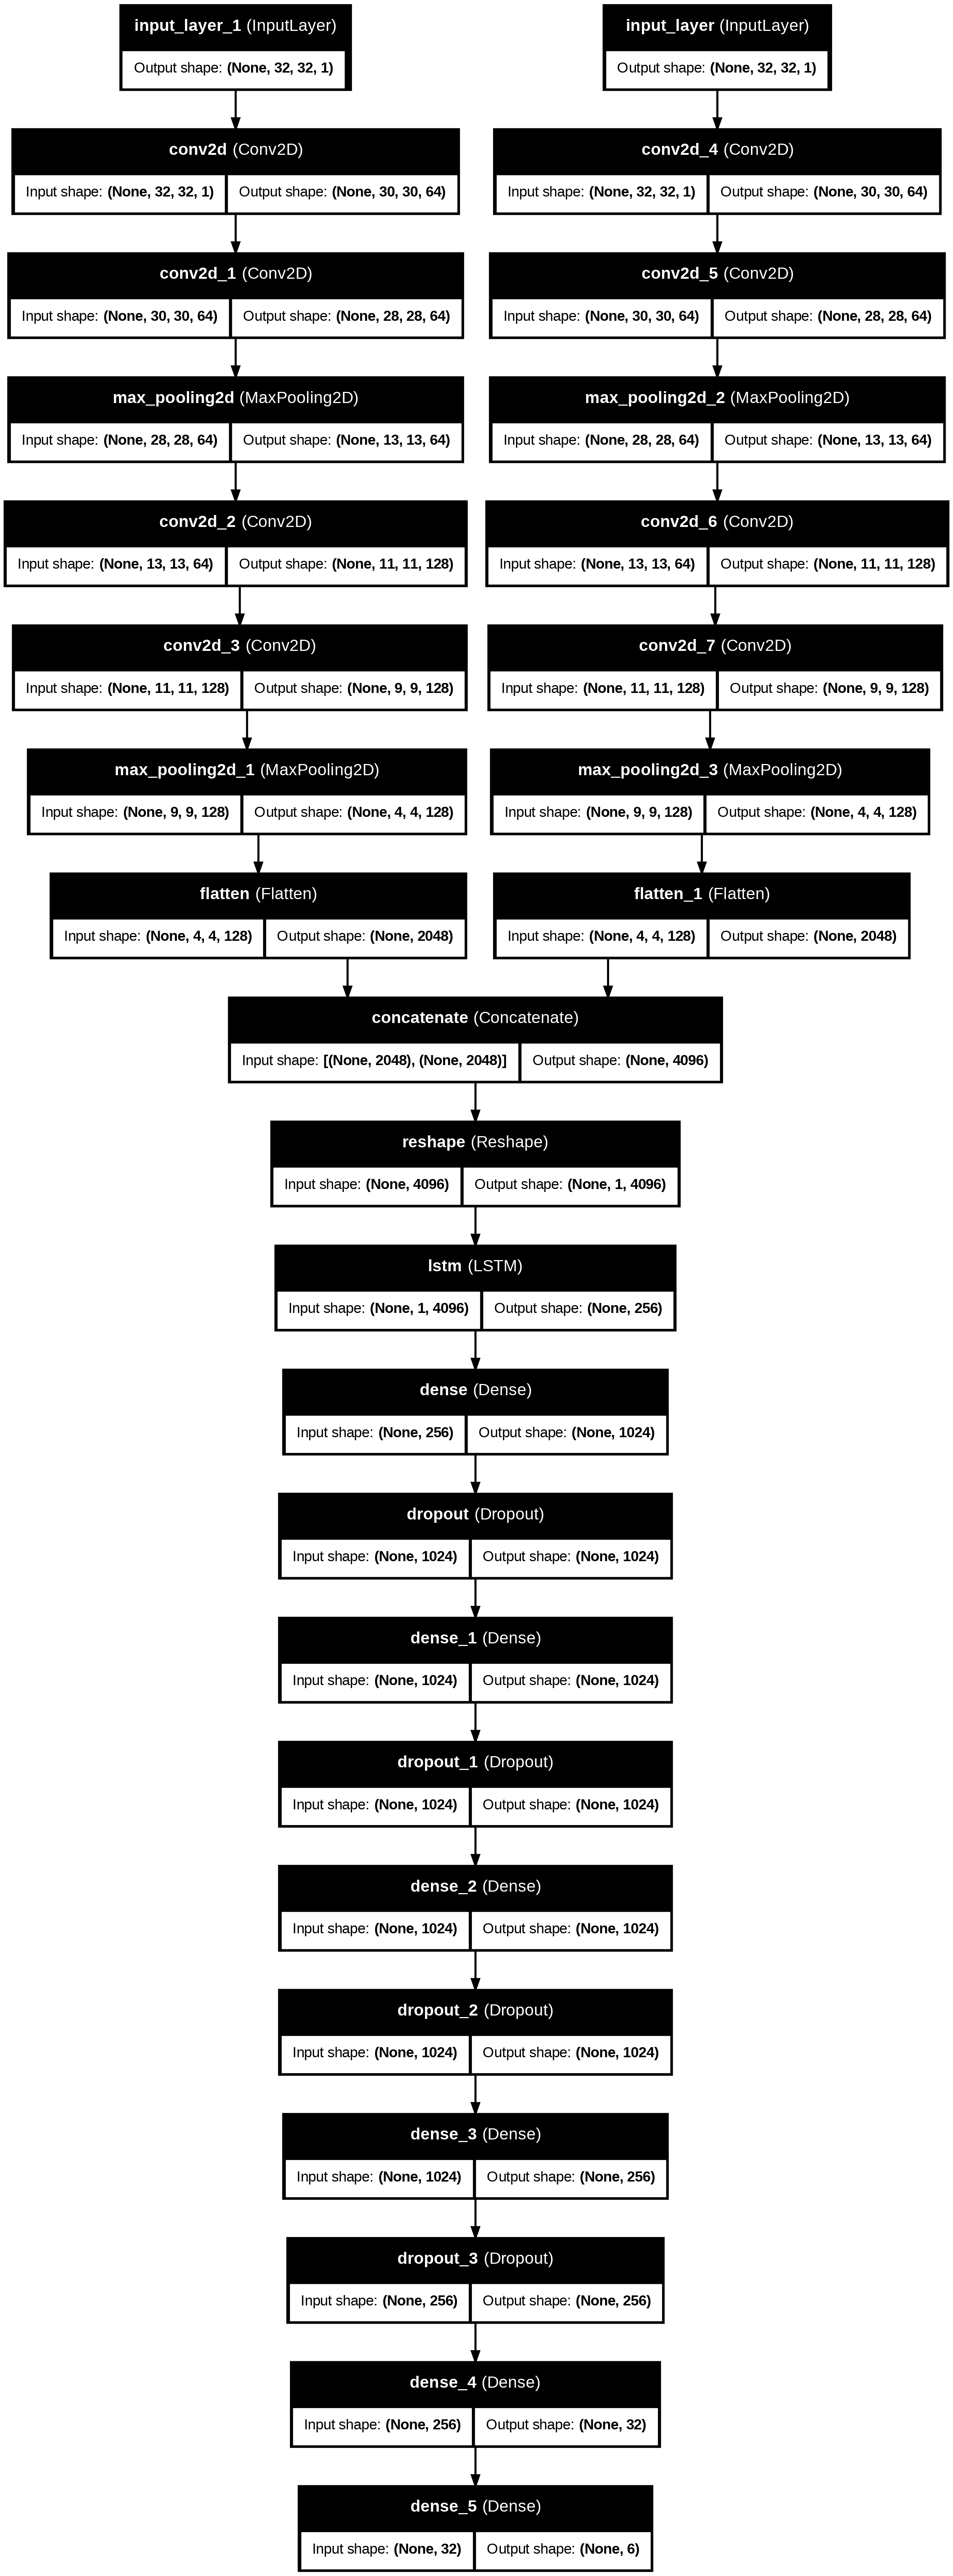

In [33]:
tk.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [15]:
history = model.fit(
    x=[X_train[:,:,:,0], X_train[:,:,:,1]],
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_test[:,:,:,0], X_test[:,:,:,1]], y_test),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25


I0000 00:00:1763016123.136842     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5783 - loss: 0.8269
Epoch 1: accuracy improved from -inf to 0.74363, saving model to model_checkpoint.weights.h5
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.5785 - loss: 0.8266 - val_accuracy: 0.8320 - val_loss: 0.2336
Epoch 2/25
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8384 - loss: 0.2398
Epoch 2: accuracy improved from 0.74363 to 0.83632, saving model to model_checkpoint.weights.h5
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.8384 - loss: 0.2398 - val_accuracy: 0.8465 - val_loss: 0.2307
Epoch 3/25
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8475 - loss: 0.2328
Epoch 3: accuracy improved from 0.83632 to 0.85939, saving model to model_checkpoint.weights.h5
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.8475 - loss: 0.2328 - val_accuracy: 0.9019 - val_loss: 0.1894
Epoch 4/25
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8898 - loss: 0.2013
Epoch 4

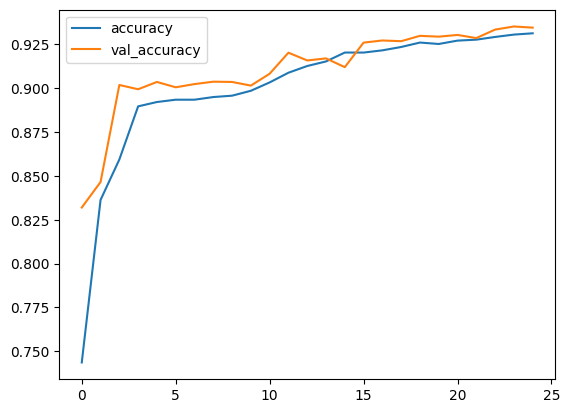

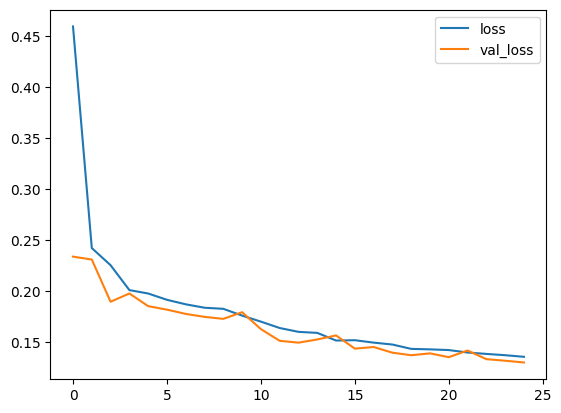

In [16]:
plt.plot(np.c_[history.history['accuracy'], history.history['val_accuracy']])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

plt.plot(np.c_[history.history['loss'], history.history['val_loss']])
plt.legend(['loss', 'val_loss'])
plt.show()

In [17]:
model_predictions = model.predict([X_test[:,:,:,0], X_test[:,:,:,1]])

615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


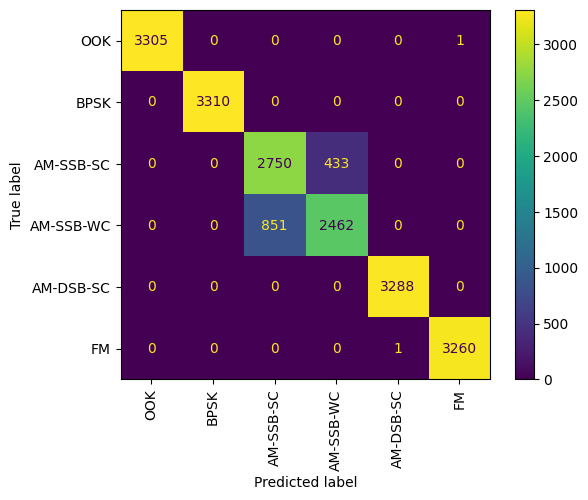

In [20]:
def convert_to_matrix(logit_list):
    logit_list = list(logit_list)
    return logit_list.index(max(logit_list))

cm = confusion_matrix(
    y_true=list(map(convert_to_matrix, y_test.values)),
    y_pred=list(map(convert_to_matrix, model_predictions)),
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_modulation_classes,)
disp.plot()
plt.xticks(rotation = 90)
plt.show()

In [21]:
# Save Model
model.save_weights('/kaggle/working/CNN_LSTMmodel.weights.h5')

In [23]:
# Use saved model weights
loaded_model = create_model()
loaded_model.load_weights('/kaggle/working/CNN_LSTMmodel.weights.h5')

loss, acc = loaded_model.evaluate([X_test[:,:,:,0], X_test[:,:,:,1]], y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 64 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


615/615 - 4s - 7ms/step - accuracy: 0.9346 - loss: 0.1298
Restored model, accuracy: 93.46%
